### Description: Sparse Bayesian learning
#### Assumptions: scalar input, scalar output

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, math, sys

Assign polynomial basis (polyPower), hyper-parameters a,b,c,d and initial hyperparameter $\alpha$ and noise precision $\rho$:

In [2]:
poly0 = [0,1,2,3,4,5,6,7,8,9,10] # powers of polynomial basis
N = len(poly0) # number of coefficients 
Wlim = [-5,5]
Nsbl = 50

Generate design matrix $\Phi$, and load observations $Y$ and input $X$: 

In [3]:
def getPhiMat(X,polyPower):
    M = len(X)
    Phi = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N): Phi[i,j] = X[i]**polyPower[j]
    return Phi
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
PhiAll = getPhiMat(Xobs,poly0)
M = len(Yobs)

Sparse Bayesian leanring through Mackay's algorithm (similar to expectation maximizations):

In [4]:
def update_SBL(iAlphaAll,iAlphaProp,iSlopeLogEvid,iCheckQsqS,iKLdist,imall,iRho,iRhoFlag,printFlag):
    iN=0
    for ii in range(0,N):
        if not np.isinf(iAlphaAll[ii,0]): iN = iN + 1 
    iAlpha = np.zeros((iN,1))
    iPhi  = np.zeros((M,iN))
    iParIndex = [int(0)]*iN
    ij=0
    for ii in range(0,N):
        if not np.isinf(iAlphaAll[ii,0]): 
            iPhi[:,ij] = PhiAll[:,ii]
            iParIndex[ij] = ii
            iAlpha[ij,0] = iAlphaAll[ii,0]
            ij = ij +1
    iA    = np.diag(iAlpha[:,0])
    iP    = np.linalg.inv(iA + iRho*np.matmul(np.transpose(iPhi),iPhi)) 
    im    = iRho*np.matmul(iP,np.matmul(np.transpose(iPhi),Yobs))
    ij=0
    for ii in range(0,N):
        if not np.isinf(iAlphaAll[ii,0]): 
            imall[ii,0] = im[ij]
            iKLdist[ii,0] = 0.5*(iAlpha[ij,0]*(iP[ij,ij] + im[ij]**2) - 1 - np.log(iAlpha[ij,0]*(iP[ij,ij])))
            ij = ij +1
        else:
            imall[ii,0] = 0.0
            iKLdist[ii,0] = -1
    itemp = np.matmul(iPhi,np.matmul(iP,np.transpose(iPhi)))
    for j in range(0,N):
        iSbar = iRho*np.sum(PhiAll[:,j]**2) - (iRho**2)*np.matmul(np.transpose(PhiAll[:,j]),np.matmul(itemp,PhiAll[:,j])) 
        iQbar = iRho*np.matmul(np.transpose(PhiAll[:,j]),Yobs) - (iRho**2)*np.matmul(np.transpose(PhiAll[:,j]),np.matmul(itemp,Yobs))
        iS    = iSbar/(1-iSbar/iAlphaAll[j,0])
        iQ    = iQbar/(1-iSbar/iAlphaAll[j,0])
        iSlopeLogEvid[j,0] = ((iS**2)/iAlphaAll[j,0] - iQ**2 + iS)/(2.0*(iAlphaAll[j,0] + iS)**2)
        iAlphaProp[j,0] = (iS**2)/(iQ**2 - iS)
        iCheckQsqS[j,0] = iQ**2 - iS
    iLogEvid = np.log(st.multivariate_normal.pdf(Yobs,[0]*M,np.matmul(iPhi,np.matmul(np.linalg.inv(iA),np.transpose(iPhi))) + np.identity(M)/iRho))
    if (iRhoFlag == 1): 
        iRho = np.divide(M - N + np.dot(np.diag(iP),iAlpha), np.sum((Yobs-np.matmul(iPhi,im))**2)) 
    if printFlag == 1:
        print("#basis: {0:3d}, LogEvid : {1:11.2e}, Rho: {2:11.2e}".format(iN,iLogEvid,iRho[0]))
        print('      alpha       mean  slopeEvid     KLdist      Q^2-s')
        for i in range(0,N):
            print("{5:3d}{0:11.2e}{1:11.2e}{2:11.2e}{3:11.2e}{4:11.2e}".format(iAlphaAll[i,0],imall[i,0],iSlopeLogEvid[i,0],iKLdist[i,0],iCheckQsqS[i,0],i))
    return iLogEvid,iRho,iParIndex

Run the sparse Bayesain learning loop to obtain optimal hyperparameter:

In [5]:
iterAlpha = np.zeros((N,Nsbl))
iterMean = np.zeros((N,Nsbl))
iterLogEvid = [0]*Nsbl
iterRho = [0]*Nsbl
mVec          = np.zeros((N,1))
Alpha         = 0.01*np.ones((N,1))
AlphaProp     = np.zeros((N,1))
KLdist        = 100*np.zeros((N,1))
slopeLogEvid  = np.zeros((N,1))
checkQsqS     = np.zeros((N,1))
maxSBLiter = 50
Rho    = 200
prevLogEvid = 0.0
LogEvid = 0.0
tolAlpha = 1e+03
tolSlope = 1e-10
prevInd = 0
curInd = 0
curIndList = [0]
rhoFlag= 1
printFlag = 0
convergeFlag = 0
i = 0
LogEvid, Rho, curIndList = update_SBL(Alpha,AlphaProp,slopeLogEvid,checkQsqS,KLdist,mVec,Rho,rhoFlag,printFlag)
while convergeFlag == 0:
    if i > N/2-1:
        if i%5 ==0:
            curInd = np.argmax(slopeLogEvid[:,0])
        else:
            curInd = np.random.randint(0,N)
    else:
        curInd = i%N
    curInd = np.random.randint(0,N)
    if i > Nsbl-2: 
        convergeFlag = 1
        print('Maximum SBL iteration reached!')
    prevLogEvid = LogEvid
    curAlpha = AlphaProp[curInd,0]
    if (checkQsqS[curInd,0] > 0 and curAlpha < tolAlpha):
        if  np.isinf(Alpha[curInd,0]): 
            Alpha[curInd,0] = curAlpha
            curText = 'Add    '
        else: 
            Alpha[curInd,0] = curAlpha
            curText = 'Update '
    else:
        if np.isinf(Alpha[curInd,0]): 
            curText = 'Neglect'
        else: 
            Alpha[curInd,0] = np.inf
            curText = 'Remove '
    #print(i,'-------Try ',curInd,': ',curText)
    LogEvid, Rho, curIndList = update_SBL(Alpha,AlphaProp,slopeLogEvid,checkQsqS,KLdist,mVec,Rho,rhoFlag,printFlag)
    prevInd = curInd
    iterMean[:,i] = mVec[:,0]
    iterAlpha[:,i] = Alpha[:,0]
    iterLogEvid[i] = LogEvid
    iterRho[i] = Rho
    i = i+1
Niter = i
print('End result:\n',curIndList,':',LogEvid,':',Rho)
LogEvid, Rho, curIndList = update_SBL(Alpha,AlphaProp,slopeLogEvid,checkQsqS,KLdist,mVec,Rho,rhoFlag,1)

Maximum SBL iteration reached!
End result:
 [0, 3, 9] : 179.2424914909327 : [108.24162949]
#basis:   3, LogEvid :    1.79e+02, Rho:    1.08e+02
      alpha       mean  slopeEvid     KLdist      Q^2-s
  0   1.01e+00   9.94e-01   2.05e-11   4.99e+00   4.63e+08
  1        inf   0.00e+00   0.00e+00  -1.00e+00  -8.61e+02
  2        inf   0.00e+00   0.00e+00  -1.00e+00  -1.22e+03
  3   1.04e+00  -9.79e-01  -3.21e-12   3.45e+00   1.04e+06
  4        inf   0.00e+00   0.00e+00  -1.00e+00  -1.18e+02
  5        inf   0.00e+00   0.00e+00  -1.00e+00  -2.13e+01
  6        inf   0.00e+00  -0.00e+00  -1.00e+00   2.92e+02
  7        inf   0.00e+00   0.00e+00  -1.00e+00  -1.78e+01
  8        inf   0.00e+00  -0.00e+00  -1.00e+00   4.89e+02
  9   2.10e+02  -5.16e-02   1.99e-10   4.09e-01   3.36e+02
 10        inf   0.00e+00  -0.00e+00  -1.00e+00   6.16e+02


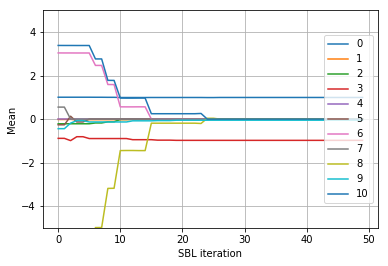

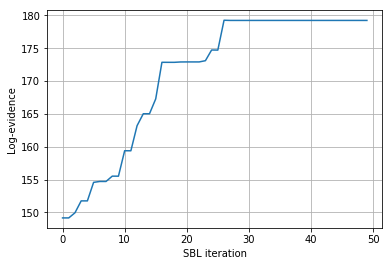

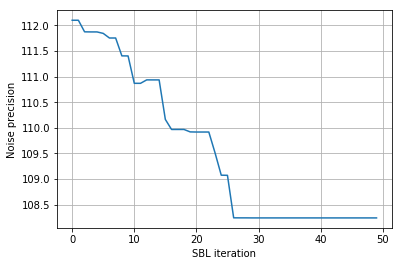

In [6]:
plt.figure(1)
for i in range(0,N): plt.plot(iterMean[i,:Niter],label=str(i))
plt.grid(True)
plt.ylabel('Mean')
plt.xlabel('SBL iteration'); 
plt.ylim(Wlim)
plt.legend(loc='right', numpoints = 1);
plt.savefig('SBL_MEAN.eps',bbox_inches='tight')

plt.figure(2)
plt.plot(iterLogEvid[:Niter])
plt.grid(True)
plt.ylabel('Log-evidence')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_LOGEVID.eps',bbox_inches='tight')

plt.figure(3)
plt.plot(iterRho[:Niter])
plt.grid(True)
plt.ylabel('Noise precision')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_RHO.eps',bbox_inches='tight')
